# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.

### Get the data
You'll be using two datasets in this project:
MNIST
CelebA
Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA. Running the GANs on MNIST will allow you to see how well your model trains sooner.
If you're using FloydHub, set data_dir to "/input" and use the FloydHub data ID "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = './input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the MNIST dataset contains images of handwritten digits. You can view the first number of examples by changing show_n_images.

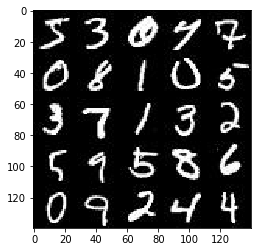

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The CelebFaces Attributes Dataset (CelebA) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations. You can view the first number of examples by changing show_n_images.

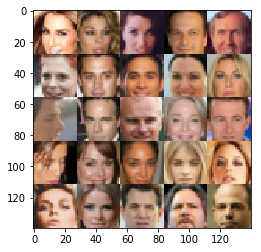

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you. The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images. The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single color channel while the CelebA images have 3 color channels (RGB color channel).

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
* model_inputs
* discriminator
* generator
* model_loss
* model_opt
* train

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/krypten/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the model_inputs function to create TF Placeholders for the Neural Network. It should create the following placeholders:
* Real input images placeholder with rank 4 using image_width, image_height, and image_channels.
* Z input placeholder with rank 2 using z_dim.
* Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='z_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_data = tf.placeholder(tf.float32, name='learning_data')
    
    return real_input, z_input, learning_data

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement discriminator to create a discriminator neural network that discriminates on images. This function should be able to reuse the variables in the neural network. Use tf.variable_scope with a scope name of "discriminator" to allow the variables to be reused. The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Layer : (28x28x3)
        h1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        # Hidden Layer 1 : (14x14x32)
        h2 = tf.layers.conv2d(h1, 64, 5, strides=2, padding='same')
        h2 = tf.maximum(alpha * h2, h2)
        # Hidden Layer 2 : (7x7x64)
        flat = tf.reshape(h2, (-1, 7*7*64))
        # Flat layer : (7*7*64)
        logits = tf.layers.dense(flat, 1)
        
        output = tf.sigmoid(logits)
        
        return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement generator to generate an image using z. This function should be able to reuse the variables in the neural network. Use tf.variable_scope with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x out_channel_dim images.

In [14]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7 * 7 * 64)

        # Reshape it to start the convolution network
        h1 = tf.reshape(h1, (-1, 7, 7, 64))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1) # LRelu
        # Hidden Layer 1 : (7x7x64)

        h2 = tf.layers.conv2d_transpose(h1, 32, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # Hidden Layer 2 : (14x14x32)
        
        logits = tf.layers.conv2d_transpose(h2, out_channel_dim, 5, strides=2, padding='same')
        # Output Layer : (28x28x3)
        
        output = tf.tanh(logits)
        return output

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement model_loss to build the GANs for training and calculate the loss. The function should return a tuple of (discriminator loss, generator loss). Use the following functions you implemented:
* discriminator(images, reuse=False)
* generator(z, out_channel_dim, is_train=True)

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement model_opt to create the optimization operations for the GANs. Use tf.trainable_variables to get all the trainable variables. Filter the variables with names that are in the discriminator and generator scope names. The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    # Trainable Variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement train to build and train the GANs. Use the following functions you implemented:
* model_inputs(image_width, image_height, image_channels, z_dim)
* model_loss(input_real, input_z, out_channel_dim)
* model_opt(d_loss, g_loss, learning_rate, beta1)

Use the show_generator_output to show generator output while you train. Running show_generator_output for every batch will drastically increase training time and increase the size of the notebook. It's recommended to print the generator output every 100 batches.

In [62]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, show_every=100, n_images=25):
    steps = 0
    # Define Image dimensions
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # Define model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Input
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run Optimizers
                _ = sess.run(d_train_opt, feed_dict={
                    input_real: batch_images,
                    input_z:    batch_z,
                    lr:         learning_rate
                })
                _ = sess.run(g_train_opt, feed_dict={
                    input_real: batch_images,
                    input_z:    batch_z,
                    lr:         learning_rate
                })
                
                # Show generator output
                if (steps % show_every == 0):
                    # Plot generator output
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                if (steps % 10 == 0):
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(steps % batch_size, batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                steps += 1  

### MNIST
Test your GANs architecture on MNIST. After 2 epochs, the GANs should be able to generate images that look like handwritten digits. Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

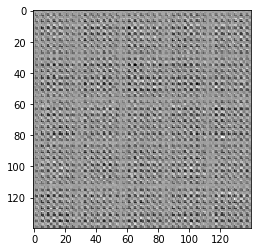

Epoch 1/2... Batch 0/128... Discriminator Loss: 1.3512... Generator Loss: 0.3371
Epoch 1/2... Batch 10/128... Discriminator Loss: 1.3950... Generator Loss: 0.5389
Epoch 1/2... Batch 20/128... Discriminator Loss: 1.0825... Generator Loss: 0.6822
Epoch 1/2... Batch 30/128... Discriminator Loss: 0.9616... Generator Loss: 1.2036
Epoch 1/2... Batch 40/128... Discriminator Loss: 1.2902... Generator Loss: 0.6167
Epoch 1/2... Batch 50/128... Discriminator Loss: 1.5852... Generator Loss: 0.4268
Epoch 1/2... Batch 60/128... Discriminator Loss: 1.8687... Generator Loss: 1.0693
Epoch 1/2... Batch 70/128... Discriminator Loss: 1.0294... Generator Loss: 0.9428
Epoch 1/2... Batch 80/128... Discriminator Loss: 1.5616... Generator Loss: 0.6270
Epoch 1/2... Batch 90/128... Discriminator Loss: 1.0813... Generator Loss: 0.8933


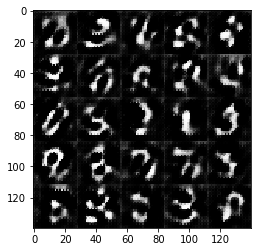

Epoch 1/2... Batch 100/128... Discriminator Loss: 1.1469... Generator Loss: 0.7783
Epoch 1/2... Batch 110/128... Discriminator Loss: 1.2833... Generator Loss: 0.6924
Epoch 1/2... Batch 120/128... Discriminator Loss: 1.1530... Generator Loss: 0.8293
Epoch 1/2... Batch 2/128... Discriminator Loss: 1.2132... Generator Loss: 0.8839
Epoch 1/2... Batch 12/128... Discriminator Loss: 1.4524... Generator Loss: 1.2627
Epoch 1/2... Batch 22/128... Discriminator Loss: 1.1471... Generator Loss: 1.2257
Epoch 1/2... Batch 32/128... Discriminator Loss: 1.3126... Generator Loss: 0.8050
Epoch 1/2... Batch 42/128... Discriminator Loss: 0.9816... Generator Loss: 1.2257
Epoch 1/2... Batch 52/128... Discriminator Loss: 1.1182... Generator Loss: 0.8142
Epoch 1/2... Batch 62/128... Discriminator Loss: 1.1510... Generator Loss: 1.1619


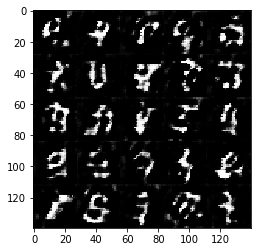

Epoch 1/2... Batch 72/128... Discriminator Loss: 1.0569... Generator Loss: 0.9707
Epoch 1/2... Batch 82/128... Discriminator Loss: 1.1756... Generator Loss: 1.0022
Epoch 1/2... Batch 92/128... Discriminator Loss: 1.1188... Generator Loss: 1.5155
Epoch 1/2... Batch 102/128... Discriminator Loss: 2.4170... Generator Loss: 2.1956
Epoch 1/2... Batch 112/128... Discriminator Loss: 1.1795... Generator Loss: 0.9111
Epoch 1/2... Batch 122/128... Discriminator Loss: 1.1283... Generator Loss: 0.7287
Epoch 1/2... Batch 4/128... Discriminator Loss: 1.5900... Generator Loss: 0.9428
Epoch 1/2... Batch 14/128... Discriminator Loss: 0.9935... Generator Loss: 1.0893
Epoch 1/2... Batch 24/128... Discriminator Loss: 1.6957... Generator Loss: 1.8024
Epoch 1/2... Batch 34/128... Discriminator Loss: 1.1217... Generator Loss: 0.8680


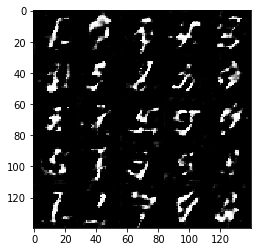

Epoch 1/2... Batch 44/128... Discriminator Loss: 0.9997... Generator Loss: 1.0145
Epoch 1/2... Batch 54/128... Discriminator Loss: 0.7987... Generator Loss: 1.2086
Epoch 1/2... Batch 64/128... Discriminator Loss: 1.0428... Generator Loss: 0.7824
Epoch 1/2... Batch 74/128... Discriminator Loss: 2.2053... Generator Loss: 0.2517
Epoch 1/2... Batch 84/128... Discriminator Loss: 0.8084... Generator Loss: 1.2419
Epoch 1/2... Batch 94/128... Discriminator Loss: 1.7784... Generator Loss: 0.2828
Epoch 1/2... Batch 104/128... Discriminator Loss: 1.0880... Generator Loss: 0.9333
Epoch 1/2... Batch 114/128... Discriminator Loss: 1.5567... Generator Loss: 0.4082
Epoch 1/2... Batch 124/128... Discriminator Loss: 0.9666... Generator Loss: 0.9376
Epoch 1/2... Batch 6/128... Discriminator Loss: 1.0090... Generator Loss: 1.2943


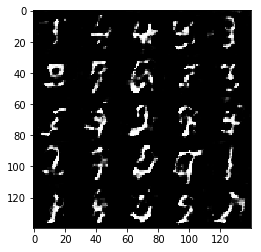

Epoch 1/2... Batch 16/128... Discriminator Loss: 1.1937... Generator Loss: 0.9608
Epoch 1/2... Batch 26/128... Discriminator Loss: 1.0936... Generator Loss: 1.0603
Epoch 1/2... Batch 36/128... Discriminator Loss: 1.2322... Generator Loss: 1.3840
Epoch 1/2... Batch 46/128... Discriminator Loss: 1.2209... Generator Loss: 2.1105
Epoch 1/2... Batch 56/128... Discriminator Loss: 0.8328... Generator Loss: 1.2310
Epoch 1/2... Batch 66/128... Discriminator Loss: 1.3143... Generator Loss: 0.8916
Epoch 1/2... Batch 76/128... Discriminator Loss: 0.9736... Generator Loss: 1.0123
Epoch 2/2... Batch 86/128... Discriminator Loss: 1.3704... Generator Loss: 1.3680
Epoch 2/2... Batch 96/128... Discriminator Loss: 1.0045... Generator Loss: 0.9206
Epoch 2/2... Batch 106/128... Discriminator Loss: 1.0265... Generator Loss: 0.9012


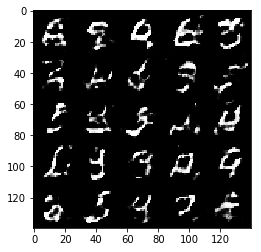

Epoch 2/2... Batch 116/128... Discriminator Loss: 1.0957... Generator Loss: 0.8393
Epoch 2/2... Batch 126/128... Discriminator Loss: 1.2466... Generator Loss: 0.5662
Epoch 2/2... Batch 8/128... Discriminator Loss: 1.0509... Generator Loss: 1.4592
Epoch 2/2... Batch 18/128... Discriminator Loss: 0.9214... Generator Loss: 1.1672
Epoch 2/2... Batch 28/128... Discriminator Loss: 1.2690... Generator Loss: 1.7964
Epoch 2/2... Batch 38/128... Discriminator Loss: 1.0948... Generator Loss: 0.7090
Epoch 2/2... Batch 48/128... Discriminator Loss: 1.0150... Generator Loss: 1.7003
Epoch 2/2... Batch 58/128... Discriminator Loss: 0.7631... Generator Loss: 1.4619
Epoch 2/2... Batch 68/128... Discriminator Loss: 1.1517... Generator Loss: 0.9467
Epoch 2/2... Batch 78/128... Discriminator Loss: 1.0843... Generator Loss: 0.9751


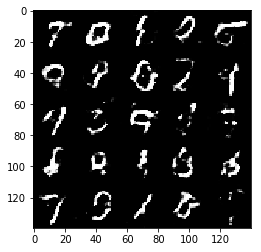

Epoch 2/2... Batch 88/128... Discriminator Loss: 1.1562... Generator Loss: 0.7581
Epoch 2/2... Batch 98/128... Discriminator Loss: 1.1237... Generator Loss: 1.2790
Epoch 2/2... Batch 108/128... Discriminator Loss: 0.9785... Generator Loss: 1.1758
Epoch 2/2... Batch 118/128... Discriminator Loss: 1.2729... Generator Loss: 1.7258
Epoch 2/2... Batch 0/128... Discriminator Loss: 5.8923... Generator Loss: 5.8696
Epoch 2/2... Batch 10/128... Discriminator Loss: 0.9293... Generator Loss: 1.4028
Epoch 2/2... Batch 20/128... Discriminator Loss: 1.2005... Generator Loss: 0.8605
Epoch 2/2... Batch 30/128... Discriminator Loss: 1.1617... Generator Loss: 0.8963
Epoch 2/2... Batch 40/128... Discriminator Loss: 1.1148... Generator Loss: 1.0277
Epoch 2/2... Batch 50/128... Discriminator Loss: 1.1387... Generator Loss: 0.8438


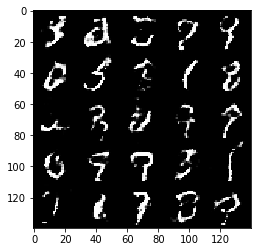

Epoch 2/2... Batch 60/128... Discriminator Loss: 1.1374... Generator Loss: 0.8480
Epoch 2/2... Batch 70/128... Discriminator Loss: 1.0736... Generator Loss: 1.0519
Epoch 2/2... Batch 80/128... Discriminator Loss: 1.0656... Generator Loss: 0.9180
Epoch 2/2... Batch 90/128... Discriminator Loss: 0.9432... Generator Loss: 1.1903
Epoch 2/2... Batch 100/128... Discriminator Loss: 0.9843... Generator Loss: 1.3044
Epoch 2/2... Batch 110/128... Discriminator Loss: 0.9892... Generator Loss: 1.1931
Epoch 2/2... Batch 120/128... Discriminator Loss: 1.1626... Generator Loss: 0.7165
Epoch 2/2... Batch 2/128... Discriminator Loss: 1.0300... Generator Loss: 1.0374
Epoch 2/2... Batch 12/128... Discriminator Loss: 1.2673... Generator Loss: 0.7331
Epoch 2/2... Batch 22/128... Discriminator Loss: 1.2970... Generator Loss: 1.3361


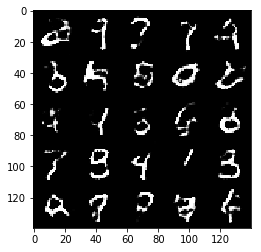

Epoch 2/2... Batch 32/128... Discriminator Loss: 1.1661... Generator Loss: 0.7242
Epoch 2/2... Batch 42/128... Discriminator Loss: 1.1685... Generator Loss: 0.9270
Epoch 2/2... Batch 52/128... Discriminator Loss: 0.9773... Generator Loss: 0.9859
Epoch 2/2... Batch 62/128... Discriminator Loss: 1.2089... Generator Loss: 0.8746
Epoch 2/2... Batch 72/128... Discriminator Loss: 1.2320... Generator Loss: 0.6610
Epoch 2/2... Batch 82/128... Discriminator Loss: 1.1402... Generator Loss: 0.8297
Epoch 2/2... Batch 92/128... Discriminator Loss: 1.2057... Generator Loss: 0.9525
Epoch 2/2... Batch 102/128... Discriminator Loss: 1.2386... Generator Loss: 0.8006
Epoch 2/2... Batch 112/128... Discriminator Loss: 1.0787... Generator Loss: 1.0944
Epoch 2/2... Batch 122/128... Discriminator Loss: 0.8878... Generator Loss: 1.2277


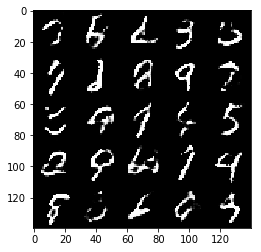

Epoch 2/2... Batch 4/128... Discriminator Loss: 1.8150... Generator Loss: 0.3067
Epoch 2/2... Batch 14/128... Discriminator Loss: 1.1445... Generator Loss: 0.9296
Epoch 2/2... Batch 24/128... Discriminator Loss: 1.1872... Generator Loss: 0.7805
Epoch 2/2... Batch 34/128... Discriminator Loss: 1.1489... Generator Loss: 0.8763


In [59]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA. It will take around 20 minutes on the average GPU to run one epoch. You can run the whole epoch or stop when it starts to generate realistic faces.

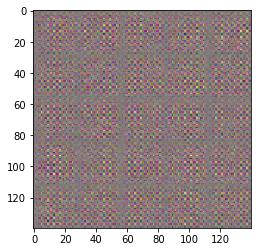

Epoch 1/1... Batch 0/128... Discriminator Loss: 1.3959... Generator Loss: 0.4043
Epoch 1/1... Batch 10/128... Discriminator Loss: 1.1084... Generator Loss: 0.6372
Epoch 1/1... Batch 20/128... Discriminator Loss: 0.3204... Generator Loss: 2.6430
Epoch 1/1... Batch 30/128... Discriminator Loss: 0.4012... Generator Loss: 1.6559
Epoch 1/1... Batch 40/128... Discriminator Loss: 1.0101... Generator Loss: 0.9881
Epoch 1/1... Batch 50/128... Discriminator Loss: 0.6255... Generator Loss: 1.4647
Epoch 1/1... Batch 60/128... Discriminator Loss: 0.9284... Generator Loss: 1.8298
Epoch 1/1... Batch 70/128... Discriminator Loss: 1.6170... Generator Loss: 0.3382
Epoch 1/1... Batch 80/128... Discriminator Loss: 1.2634... Generator Loss: 1.2002
Epoch 1/1... Batch 90/128... Discriminator Loss: 1.2066... Generator Loss: 1.1439


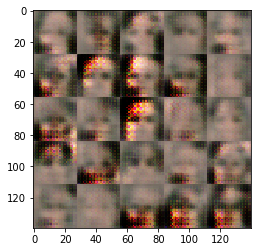

Epoch 1/1... Batch 100/128... Discriminator Loss: 1.2932... Generator Loss: 0.7351
Epoch 1/1... Batch 110/128... Discriminator Loss: 1.0845... Generator Loss: 1.2653
Epoch 1/1... Batch 120/128... Discriminator Loss: 0.9189... Generator Loss: 1.0076
Epoch 1/1... Batch 2/128... Discriminator Loss: 1.2860... Generator Loss: 0.8868
Epoch 1/1... Batch 12/128... Discriminator Loss: 1.2109... Generator Loss: 0.8597
Epoch 1/1... Batch 22/128... Discriminator Loss: 1.2179... Generator Loss: 0.8159
Epoch 1/1... Batch 32/128... Discriminator Loss: 1.1911... Generator Loss: 1.0552
Epoch 1/1... Batch 42/128... Discriminator Loss: 1.2549... Generator Loss: 0.7510
Epoch 1/1... Batch 52/128... Discriminator Loss: 1.2646... Generator Loss: 0.8988
Epoch 1/1... Batch 62/128... Discriminator Loss: 1.6764... Generator Loss: 1.8298


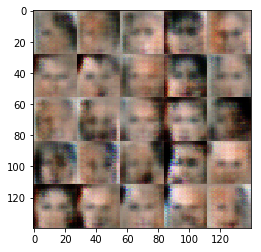

Epoch 1/1... Batch 72/128... Discriminator Loss: 1.2270... Generator Loss: 0.8195
Epoch 1/1... Batch 82/128... Discriminator Loss: 1.2895... Generator Loss: 0.8422
Epoch 1/1... Batch 92/128... Discriminator Loss: 1.2326... Generator Loss: 0.9249
Epoch 1/1... Batch 102/128... Discriminator Loss: 1.2946... Generator Loss: 0.6554
Epoch 1/1... Batch 112/128... Discriminator Loss: 1.2839... Generator Loss: 0.7683
Epoch 1/1... Batch 122/128... Discriminator Loss: 1.3124... Generator Loss: 0.6837
Epoch 1/1... Batch 4/128... Discriminator Loss: 1.2528... Generator Loss: 0.7226
Epoch 1/1... Batch 14/128... Discriminator Loss: 1.3649... Generator Loss: 0.8950
Epoch 1/1... Batch 24/128... Discriminator Loss: 1.2704... Generator Loss: 0.7784
Epoch 1/1... Batch 34/128... Discriminator Loss: 1.4935... Generator Loss: 1.1398


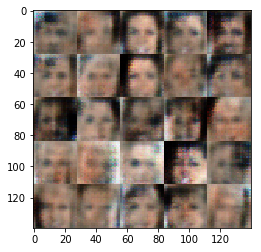

Epoch 1/1... Batch 44/128... Discriminator Loss: 1.3218... Generator Loss: 0.6380
Epoch 1/1... Batch 54/128... Discriminator Loss: 1.3747... Generator Loss: 0.7489
Epoch 1/1... Batch 64/128... Discriminator Loss: 1.3072... Generator Loss: 0.9038
Epoch 1/1... Batch 74/128... Discriminator Loss: 1.4020... Generator Loss: 0.7280
Epoch 1/1... Batch 84/128... Discriminator Loss: 1.2843... Generator Loss: 0.7778
Epoch 1/1... Batch 94/128... Discriminator Loss: 1.2723... Generator Loss: 0.9271
Epoch 1/1... Batch 104/128... Discriminator Loss: 1.3164... Generator Loss: 0.7621
Epoch 1/1... Batch 114/128... Discriminator Loss: 1.3701... Generator Loss: 0.6263
Epoch 1/1... Batch 124/128... Discriminator Loss: 1.4774... Generator Loss: 0.4627
Epoch 1/1... Batch 6/128... Discriminator Loss: 1.7080... Generator Loss: 0.3721


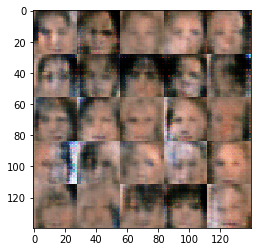

Epoch 1/1... Batch 16/128... Discriminator Loss: 1.3595... Generator Loss: 0.6715
Epoch 1/1... Batch 26/128... Discriminator Loss: 1.3377... Generator Loss: 0.6852
Epoch 1/1... Batch 36/128... Discriminator Loss: 1.4197... Generator Loss: 0.6714
Epoch 1/1... Batch 46/128... Discriminator Loss: 1.4902... Generator Loss: 0.5209
Epoch 1/1... Batch 56/128... Discriminator Loss: 1.5442... Generator Loss: 0.6740
Epoch 1/1... Batch 66/128... Discriminator Loss: 1.4285... Generator Loss: 0.6393
Epoch 1/1... Batch 76/128... Discriminator Loss: 1.4260... Generator Loss: 0.6788
Epoch 1/1... Batch 86/128... Discriminator Loss: 1.3673... Generator Loss: 0.6491
Epoch 1/1... Batch 96/128... Discriminator Loss: 1.3248... Generator Loss: 0.6303
Epoch 1/1... Batch 106/128... Discriminator Loss: 1.3571... Generator Loss: 0.7140


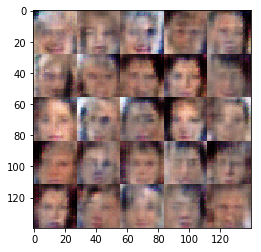

Epoch 1/1... Batch 116/128... Discriminator Loss: 1.2811... Generator Loss: 0.7936
Epoch 1/1... Batch 126/128... Discriminator Loss: 1.7327... Generator Loss: 1.3973
Epoch 1/1... Batch 8/128... Discriminator Loss: 1.4055... Generator Loss: 0.7230
Epoch 1/1... Batch 18/128... Discriminator Loss: 1.4245... Generator Loss: 0.7711
Epoch 1/1... Batch 28/128... Discriminator Loss: 1.3926... Generator Loss: 0.6871
Epoch 1/1... Batch 38/128... Discriminator Loss: 1.2516... Generator Loss: 0.7267
Epoch 1/1... Batch 48/128... Discriminator Loss: 1.5262... Generator Loss: 0.9119
Epoch 1/1... Batch 58/128... Discriminator Loss: 1.4504... Generator Loss: 0.5263
Epoch 1/1... Batch 68/128... Discriminator Loss: 1.3722... Generator Loss: 0.7029
Epoch 1/1... Batch 78/128... Discriminator Loss: 1.3875... Generator Loss: 0.6251


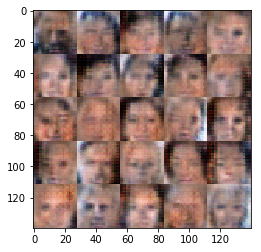

Epoch 1/1... Batch 88/128... Discriminator Loss: 1.3754... Generator Loss: 0.6243
Epoch 1/1... Batch 98/128... Discriminator Loss: 1.3656... Generator Loss: 0.6107
Epoch 1/1... Batch 108/128... Discriminator Loss: 1.3399... Generator Loss: 0.7406
Epoch 1/1... Batch 118/128... Discriminator Loss: 1.4251... Generator Loss: 0.8272
Epoch 1/1... Batch 0/128... Discriminator Loss: 1.2927... Generator Loss: 0.7698
Epoch 1/1... Batch 10/128... Discriminator Loss: 1.3042... Generator Loss: 0.7600
Epoch 1/1... Batch 20/128... Discriminator Loss: 1.5051... Generator Loss: 0.7103
Epoch 1/1... Batch 30/128... Discriminator Loss: 1.4538... Generator Loss: 0.6802
Epoch 1/1... Batch 40/128... Discriminator Loss: 1.3558... Generator Loss: 0.7103
Epoch 1/1... Batch 50/128... Discriminator Loss: 1.3270... Generator Loss: 0.6971


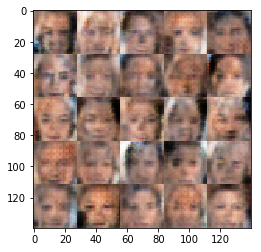

Epoch 1/1... Batch 60/128... Discriminator Loss: 1.5360... Generator Loss: 1.0889
Epoch 1/1... Batch 70/128... Discriminator Loss: 1.3528... Generator Loss: 0.7210
Epoch 1/1... Batch 80/128... Discriminator Loss: 1.3808... Generator Loss: 0.7692
Epoch 1/1... Batch 90/128... Discriminator Loss: 1.3806... Generator Loss: 0.5739
Epoch 1/1... Batch 100/128... Discriminator Loss: 1.4147... Generator Loss: 0.5928
Epoch 1/1... Batch 110/128... Discriminator Loss: 1.3132... Generator Loss: 0.7271
Epoch 1/1... Batch 120/128... Discriminator Loss: 1.4085... Generator Loss: 0.7332
Epoch 1/1... Batch 2/128... Discriminator Loss: 1.3818... Generator Loss: 0.6523
Epoch 1/1... Batch 12/128... Discriminator Loss: 1.4304... Generator Loss: 0.4931
Epoch 1/1... Batch 22/128... Discriminator Loss: 1.3073... Generator Loss: 0.7008


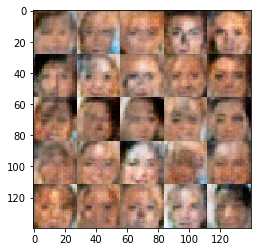

Epoch 1/1... Batch 32/128... Discriminator Loss: 1.3502... Generator Loss: 0.6620
Epoch 1/1... Batch 42/128... Discriminator Loss: 1.3484... Generator Loss: 0.6842
Epoch 1/1... Batch 52/128... Discriminator Loss: 1.2712... Generator Loss: 0.7683
Epoch 1/1... Batch 62/128... Discriminator Loss: 1.3273... Generator Loss: 0.8291
Epoch 1/1... Batch 72/128... Discriminator Loss: 1.4267... Generator Loss: 0.7309
Epoch 1/1... Batch 82/128... Discriminator Loss: 1.5117... Generator Loss: 0.5226
Epoch 1/1... Batch 92/128... Discriminator Loss: 1.2916... Generator Loss: 0.6322
Epoch 1/1... Batch 102/128... Discriminator Loss: 1.3143... Generator Loss: 0.7763
Epoch 1/1... Batch 112/128... Discriminator Loss: 1.4258... Generator Loss: 0.7197
Epoch 1/1... Batch 122/128... Discriminator Loss: 1.3734... Generator Loss: 0.6936


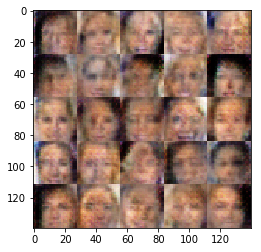

Epoch 1/1... Batch 4/128... Discriminator Loss: 1.3094... Generator Loss: 0.6910
Epoch 1/1... Batch 14/128... Discriminator Loss: 1.4109... Generator Loss: 0.6678
Epoch 1/1... Batch 24/128... Discriminator Loss: 1.3316... Generator Loss: 0.6704
Epoch 1/1... Batch 34/128... Discriminator Loss: 1.3227... Generator Loss: 0.7204
Epoch 1/1... Batch 44/128... Discriminator Loss: 1.4263... Generator Loss: 0.7252
Epoch 1/1... Batch 54/128... Discriminator Loss: 1.4562... Generator Loss: 0.7087
Epoch 1/1... Batch 64/128... Discriminator Loss: 1.3361... Generator Loss: 0.7019
Epoch 1/1... Batch 74/128... Discriminator Loss: 1.3734... Generator Loss: 0.6853
Epoch 1/1... Batch 84/128... Discriminator Loss: 1.4538... Generator Loss: 0.6327
Epoch 1/1... Batch 94/128... Discriminator Loss: 1.3187... Generator Loss: 0.6694


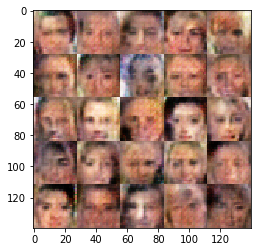

Epoch 1/1... Batch 104/128... Discriminator Loss: 1.3718... Generator Loss: 0.8092
Epoch 1/1... Batch 114/128... Discriminator Loss: 1.2949... Generator Loss: 0.6800
Epoch 1/1... Batch 124/128... Discriminator Loss: 1.3485... Generator Loss: 0.6905
Epoch 1/1... Batch 6/128... Discriminator Loss: 1.3516... Generator Loss: 0.6795
Epoch 1/1... Batch 16/128... Discriminator Loss: 1.3273... Generator Loss: 0.7411
Epoch 1/1... Batch 26/128... Discriminator Loss: 1.3605... Generator Loss: 0.7092
Epoch 1/1... Batch 36/128... Discriminator Loss: 1.3769... Generator Loss: 0.7190
Epoch 1/1... Batch 46/128... Discriminator Loss: 1.3582... Generator Loss: 0.7659
Epoch 1/1... Batch 56/128... Discriminator Loss: 1.4054... Generator Loss: 0.7636
Epoch 1/1... Batch 66/128... Discriminator Loss: 1.3377... Generator Loss: 0.7777


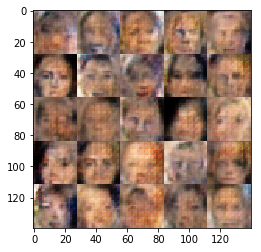

Epoch 1/1... Batch 76/128... Discriminator Loss: 1.5027... Generator Loss: 0.5791
Epoch 1/1... Batch 86/128... Discriminator Loss: 1.5021... Generator Loss: 0.4989
Epoch 1/1... Batch 96/128... Discriminator Loss: 1.5258... Generator Loss: 0.5091
Epoch 1/1... Batch 106/128... Discriminator Loss: 1.3166... Generator Loss: 0.6979
Epoch 1/1... Batch 116/128... Discriminator Loss: 1.7872... Generator Loss: 1.5628
Epoch 1/1... Batch 126/128... Discriminator Loss: 1.3406... Generator Loss: 0.7014
Epoch 1/1... Batch 8/128... Discriminator Loss: 1.3544... Generator Loss: 0.7499
Epoch 1/1... Batch 18/128... Discriminator Loss: 1.4714... Generator Loss: 0.5170
Epoch 1/1... Batch 28/128... Discriminator Loss: 1.3594... Generator Loss: 0.7100
Epoch 1/1... Batch 38/128... Discriminator Loss: 1.3939... Generator Loss: 0.6409


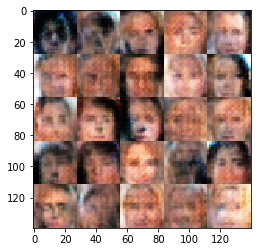

Epoch 1/1... Batch 48/128... Discriminator Loss: 1.4206... Generator Loss: 0.6162
Epoch 1/1... Batch 58/128... Discriminator Loss: 1.3123... Generator Loss: 0.8247
Epoch 1/1... Batch 68/128... Discriminator Loss: 1.2745... Generator Loss: 0.6914
Epoch 1/1... Batch 78/128... Discriminator Loss: 1.3904... Generator Loss: 0.6342
Epoch 1/1... Batch 88/128... Discriminator Loss: 1.4808... Generator Loss: 0.6461
Epoch 1/1... Batch 98/128... Discriminator Loss: 1.4398... Generator Loss: 0.5546
Epoch 1/1... Batch 108/128... Discriminator Loss: 1.3104... Generator Loss: 0.7970
Epoch 1/1... Batch 118/128... Discriminator Loss: 1.3908... Generator Loss: 0.7230
Epoch 1/1... Batch 0/128... Discriminator Loss: 1.4171... Generator Loss: 0.7032
Epoch 1/1... Batch 10/128... Discriminator Loss: 1.5503... Generator Loss: 0.5451


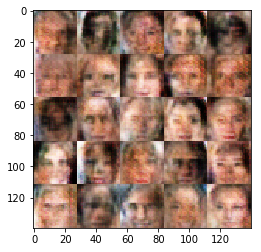

Epoch 1/1... Batch 20/128... Discriminator Loss: 1.4541... Generator Loss: 0.6747
Epoch 1/1... Batch 30/128... Discriminator Loss: 1.2819... Generator Loss: 0.7476
Epoch 1/1... Batch 40/128... Discriminator Loss: 1.3780... Generator Loss: 0.4811
Epoch 1/1... Batch 50/128... Discriminator Loss: 1.2984... Generator Loss: 0.6806
Epoch 1/1... Batch 60/128... Discriminator Loss: 1.3965... Generator Loss: 0.7371
Epoch 1/1... Batch 70/128... Discriminator Loss: 1.4498... Generator Loss: 0.6769
Epoch 1/1... Batch 80/128... Discriminator Loss: 1.3501... Generator Loss: 0.6302
Epoch 1/1... Batch 90/128... Discriminator Loss: 1.2928... Generator Loss: 0.7341
Epoch 1/1... Batch 100/128... Discriminator Loss: 1.3883... Generator Loss: 0.7690
Epoch 1/1... Batch 110/128... Discriminator Loss: 1.3761... Generator Loss: 0.7243


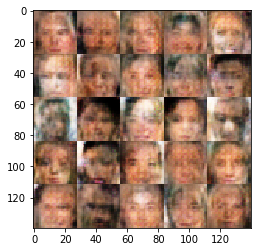

Epoch 1/1... Batch 120/128... Discriminator Loss: 1.3331... Generator Loss: 0.7198
Epoch 1/1... Batch 2/128... Discriminator Loss: 1.4079... Generator Loss: 0.5903
Epoch 1/1... Batch 12/128... Discriminator Loss: 1.3998... Generator Loss: 0.7943
Epoch 1/1... Batch 22/128... Discriminator Loss: 1.4478... Generator Loss: 0.6779
Epoch 1/1... Batch 32/128... Discriminator Loss: 1.4624... Generator Loss: 0.5876
Epoch 1/1... Batch 42/128... Discriminator Loss: 1.2740... Generator Loss: 0.7483
Epoch 1/1... Batch 52/128... Discriminator Loss: 1.5840... Generator Loss: 0.9963
Epoch 1/1... Batch 62/128... Discriminator Loss: 1.3857... Generator Loss: 0.6870
Epoch 1/1... Batch 72/128... Discriminator Loss: 1.3231... Generator Loss: 0.7217
Epoch 1/1... Batch 82/128... Discriminator Loss: 1.5795... Generator Loss: 1.2212


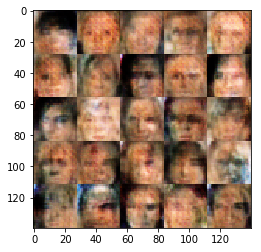

Epoch 1/1... Batch 92/128... Discriminator Loss: 1.2969... Generator Loss: 0.7329
Epoch 1/1... Batch 102/128... Discriminator Loss: 1.3498... Generator Loss: 0.6224
Epoch 1/1... Batch 112/128... Discriminator Loss: 1.3859... Generator Loss: 0.7510
Epoch 1/1... Batch 122/128... Discriminator Loss: 1.3786... Generator Loss: 0.8178
Epoch 1/1... Batch 4/128... Discriminator Loss: 1.4116... Generator Loss: 0.7275
Epoch 1/1... Batch 14/128... Discriminator Loss: 1.5268... Generator Loss: 0.5321
Epoch 1/1... Batch 24/128... Discriminator Loss: 1.3974... Generator Loss: 0.6561
Epoch 1/1... Batch 34/128... Discriminator Loss: 1.3417... Generator Loss: 0.6155
Epoch 1/1... Batch 44/128... Discriminator Loss: 1.4344... Generator Loss: 0.5772


In [63]:
batch_size = 128
z_dim = 100
learning_rate = 0.003
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.